In [1]:
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def load_and_prepare_data(path: str) -> pd.DataFrame:
    """
    Load dataset and rename columns.

    Args:
        path (str): File path to CSV dataset.

    Returns:
        pd.DataFrame: Prepared dataframe with columns ['text', 'label'].
    """
    data = pd.read_csv(path)
    data.rename(columns={'sentence': 'text', 'emotion': 'label'}, inplace=True)
    return data

data = load_and_prepare_data(r"D:\Grad_Proj\project\combined_emotion.csv")
data

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
422741,i begun to feel distressed for you,fear
422742,i left feeling annoyed and angry thinking that...,anger
422743,i were to ever get married i d have everything...,joy
422744,i feel reluctant in applying there because i w...,fear


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    422746 non-null  object
 1   label   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [4]:
data['No_of_Chars'] = data['text'].apply(len)
data['No_of_Words'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis= 1).apply(len)
data['No_of_Sents'] = data.apply(lambda row: nltk.sent_tokenize(row['text']), axis= 1).apply(len)

data.describe()

,No_of_Chars,No_of_Words,No_of_Sents
count,422746.000000,422746.000000,422746.0
mean,97.033980,19.220179,1.0
std,56.198156,11.057121,0.0
min,2.000000,1.000000,1.0
25%,54.000000,11.000000,1.0
50%,86.000000,17.000000,1.0
75%,128.000000,25.000000,1.0
max,830.000000,178.000000,1.0


In [5]:
def encode_labels(df: pd.DataFrame, col: str) -> (pd.DataFrame, LabelEncoder):
    """
    Encode categorical labels to integers.

    Args:
        df (pd.DataFrame): Input dataframe.
        col (str): Column name of labels.

    Returns:
        tuple: Dataframe with encoded labels, fitted LabelEncoder.
    """
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df, le

data, le = encode_labels(data, 'label')


C:\Users\Elgabrey\AppData\Local\Temp\ipykernel_17664\575512067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.countplot(x= data['label'], palette= cols_color)


Text(0, 0.5, 'count of classes')

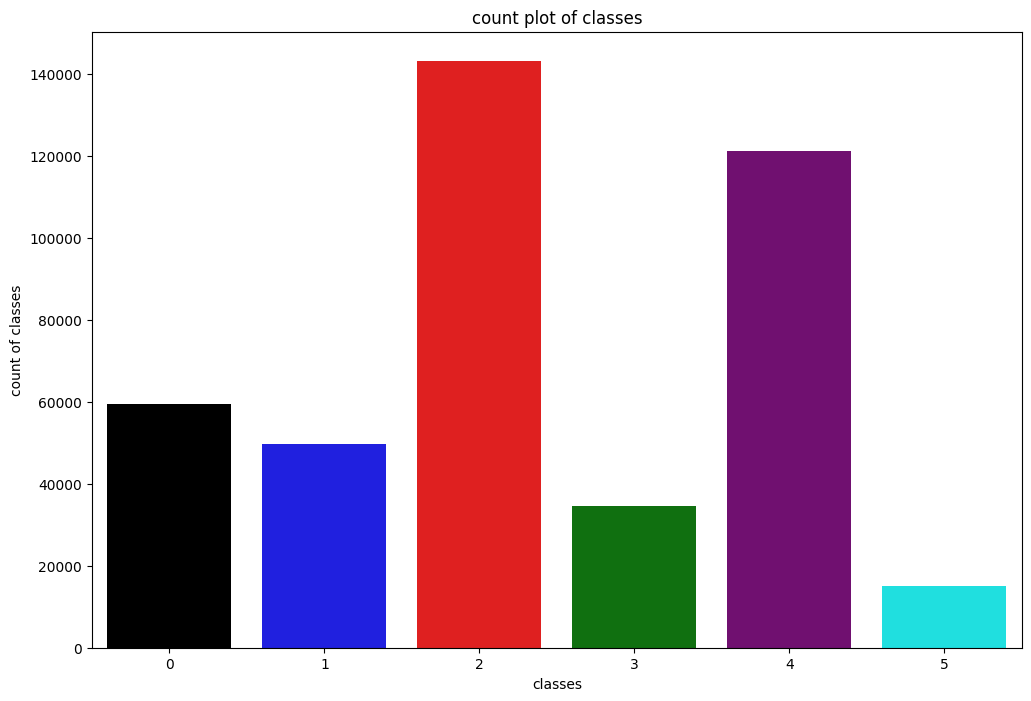

In [6]:
cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes')

<Figure size 1200x800 with 0 Axes>

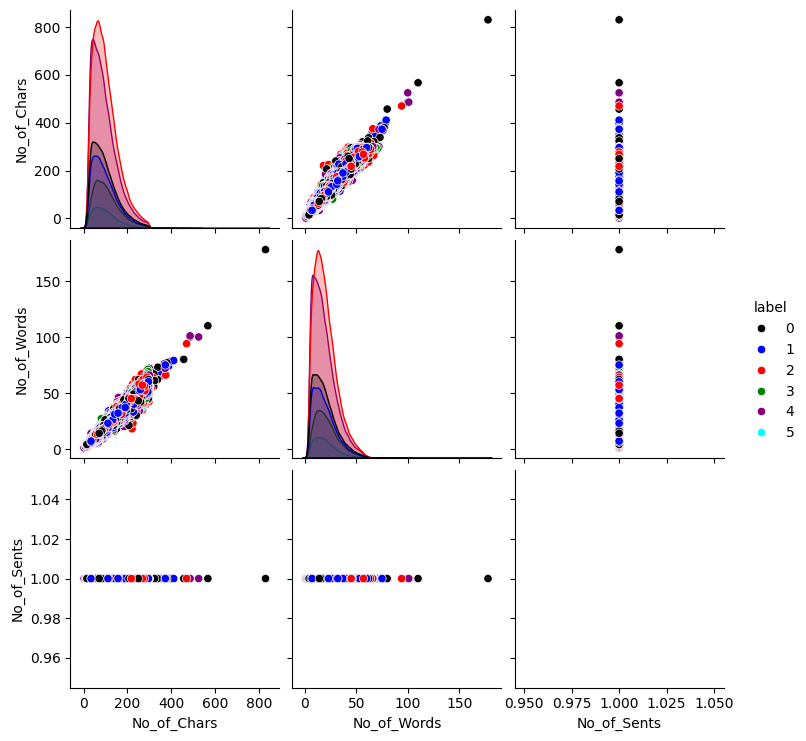

In [7]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data= data, hue= 'label', palette= cols_color)
plt.show(fg)

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess_text(text: str) -> str:
    """
    Preprocess text: lowercase, remove non-alphabetic chars, tokenize, remove stopwords, lemmatize.

    Args:
        text (str): Raw input text.

    Returns:
        str: Cleaned and lemmatized text.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['lemmatized_words'] = data['text'].apply(preprocess_text)

C:\Users\Elgabrey\AppData\Local\Temp\ipykernel_17664\575512067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.countplot(x= data['label'], palette= cols_color)


Text(0, 0.5, 'count of classes')

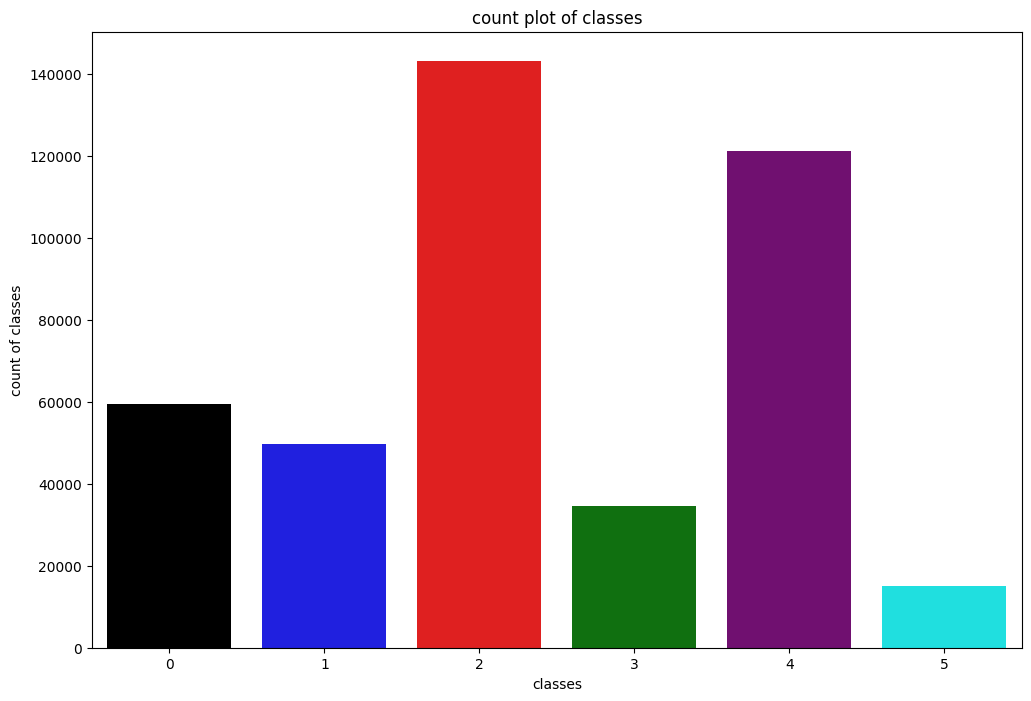

In [10]:
cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes')

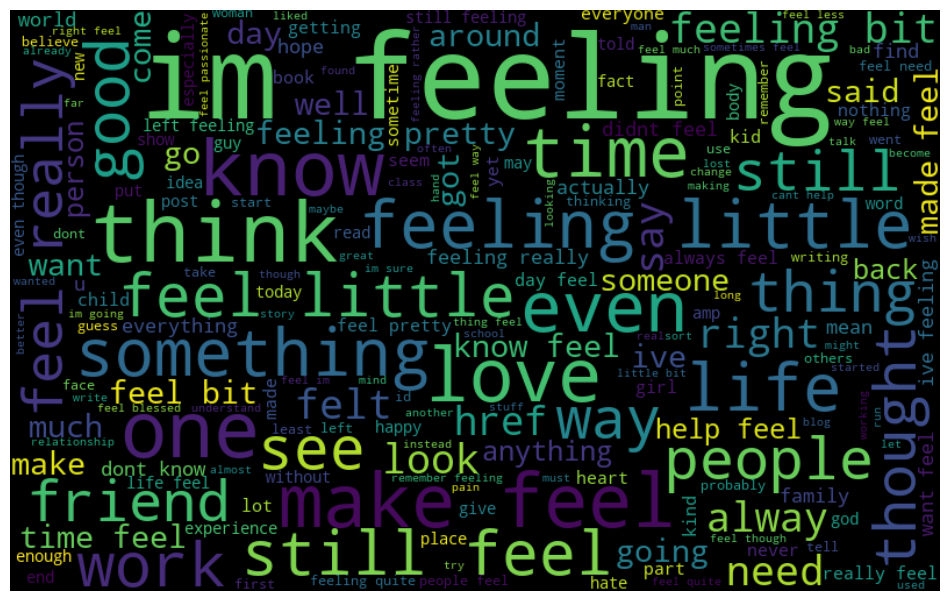

In [11]:
all_words = " ".join(sentence for sentence in data['lemmatized_words'])
all_words

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
tfidf = TfidfVectorizer(max_features=5000, max_df=0.9, min_df=2, stop_words='english')

def vectorize_text(df: pd.DataFrame, text_col: str, vectorizer: TfidfVectorizer):
    """
    Vectorize text column using TF-IDF.

    Args:
        df (pd.DataFrame): Dataframe containing text data.
        text_col (str): Name of the column with preprocessed text.
        vectorizer (TfidfVectorizer): Initialized vectorizer.

    Returns:
        sparse matrix: TF-IDF features matrix.
    """
    X = vectorizer.fit_transform(df[text_col])
    return X

sampled_data = data.sample(frac=0.4, random_state=42)
X = vectorize_text(data, 'lemmatized_words', tfidf)
y = data['label']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_balanced))


Before SMOTE: [ 47454  39719 114453  27643  96949  11978]
After SMOTE: [114453 114453 114453 114453 114453 114453]


In [14]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({2: 114453, 4: 96949, 0: 47454, 1: 39719, 3: 27643, 5: 11978})
After SMOTE: Counter({4: 114453, 1: 114453, 2: 114453, 0: 114453, 3: 114453, 5: 114453})


In [15]:
row = X[0].toarray().flatten()
for i, val in enumerate(row):
    if val != 0:
        print(f'index {i}: {val}')


index 1662: 0.09886139498403329
index 2067: 0.6461740369485999
index 2073: 0.563977327840801
index 2087: 0.42366309760295373
index 3535: 0.274088839550939


Accuracy: 0.8553
F1 Score (weighted): 0.8578
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     11863
           1       0.78      0.83      0.81      9930
           2       0.91      0.86      0.88     28614
           3       0.65      0.76      0.70      6911
           4       0.94      0.89      0.91     24238
           5       0.60      0.70      0.64      2994

    accuracy                           0.86     84550
   macro avg       0.79      0.82      0.80     84550
weighted avg       0.86      0.86      0.86     84550



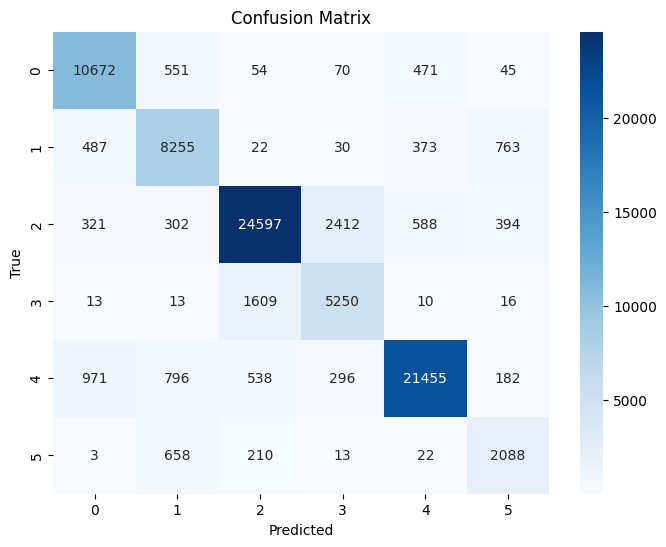

F1 Score: 0.8578010693436108


In [16]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate on test set.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Testing features and labels.

    Returns:
        model: Trained Random Forest model.
    """
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    return model

random_forest_model = train_and_evaluate(X_train_balanced, y_train_balanced, X_test, y_test)


In [17]:
""" models = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print("-" * 30)
 """

' models = {\n    \'Random Forest\': RandomForestClassifier(),\n    \'Naive Bayes\': MultinomialNB(),\n    \'SVM\': SVC(),\n    \'KNN\': KNeighborsClassifier()\n}\n\nfor name, model in models.items():\n    model.fit(X_train_balanced, y_train_balanced)\n    y_pred = model.predict(X_test)\n    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")\n    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average=\'weighted\'):.2f}")\n    print("-" * 30)\n '

In [18]:
""" cv_scores = cross_val_score(random_forest, X_train_balanced, y_train_balanced, cv=5, scoring='f1_weighted')
print("Cross-Validated F1 Scores:", cv_scores)
print("Average F1:", np.mean(cv_scores))
 """

' cv_scores = cross_val_score(random_forest, X_train_balanced, y_train_balanced, cv=5, scoring=\'f1_weighted\')\nprint("Cross-Validated F1 Scores:", cv_scores)\nprint("Average F1:", np.mean(cv_scores))\n '

In [19]:
def predict_emotion(text: str, model, vectorizer, label_encoder) -> str:
    """
    Predict emotion label for a new text.

    Args:
        text (str): Input raw text.
        model: Trained classification model.
        vectorizer: TF-IDF vectorizer.
        label_encoder: LabelEncoder for decoding labels.

    Returns:
        str: Predicted emotion label.
    """
    processed = preprocess_text(text)
    vect_text = vectorizer.transform([processed])
    prediction = model.predict(vect_text)
    return label_encoder.inverse_transform(prediction)[0]

# مثال تجربة
print(predict_emotion("I feel so happy and joyful today!", random_forest_model, tfidf, le))


joy


In [20]:
# تحميل قاعدة بيانات التوصية
recommendation_db = pd.read_csv("recommendation_database.csv")

# عرض عينة من البيانات
print(recommendation_db.head())



                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness


In [21]:
recommendation_db = pd.read_csv("recommendation_database.csv")

In [22]:
recommendation_db['emotion'].value_counts()

emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [23]:
def filter_by_keywords(df: pd.DataFrame, include_keywords=None, exclude_keywords=None) -> pd.DataFrame:
    """
    ترشيح المحتوى بناءً على كلمات مفتاحية.
    
    Args:
        df (pd.DataFrame): جدول المحتوى.
        include_keywords (list): كلمات يجب أن يحتويها النص.
        exclude_keywords (list): كلمات يجب ألا يحتويها النص.
    
    Returns:
        pd.DataFrame: محتوى بعد التصفية.
    """
    if include_keywords:
        pattern = '|'.join(include_keywords)
        df = df[df['text'].str.contains(pattern, case=False, na=False)]
    
    if exclude_keywords:
        pattern = '|'.join(exclude_keywords)
        df = df[~df['text'].str.contains(pattern, case=False, na=False)]

    return df


In [24]:
# خريطة من الشعور الحالي إلى الشعور المستهدف
mood_map = {
    'sadness': ['joy', 'calm', 'amusement'],
    'anger': ['calm', 'joy'],
    'fear': ['calm', 'confidence'],
    'joy': ['joy'],
    'surprise': ['calm', 'joy'],
    'love': ['joy', 'love'],
    'misery': ['hope', 'calm', 'joy'],
    'gratitude': ['joy', 'love'],
    'disgust': ['calm', 'neutral']

    # أضف المزيد حسب الحاجة
}

def recommend_content_filtered(
    user_text: str,
    model,
    vectorizer,
    label_encoder,
    rec_db: pd.DataFrame,
    include_keywords=None,
    exclude_keywords=None
) -> pd.DataFrame:
    """
    توصية بمحتوى مع فلترة اختيارية بناءً على الكلمات المفتاحية.
    """
    user_emotion = predict_emotion(user_text, model, vectorizer, label_encoder)
    print(f"🔍 Detected Emotion: {user_emotion}")

    target_emotions = mood_map.get(user_emotion, ['joy', 'calm', 'confidence'])
    recommended = rec_db[rec_db['emotion'].isin(target_emotions)]

    # تطبيق الفلترة
    filtered = filter_by_keywords(recommended, include_keywords, exclude_keywords)

    if filtered.empty:
        print("⚠️ لا يوجد محتوى يلبي معايير الفلترة. عرض نتائج بدون فلترة.")
        return recommended[['text', 'emotion']].sample(min(3, len(recommended)))

    return filtered[['text', 'emotion']].sample(min(3, len(filtered)))


In [25]:
recs = recommend_content_filtered(
    user_text="I'm overwhelmed and anxious",
    model=random_forest_model,
    vectorizer=tfidf,
    label_encoder=le,
    rec_db=recommendation_db,
    include_keywords=["meditation", "relax", "happy"],
    exclude_keywords=["war", "violence"]
)

print("📌 محتوى موصى به بعد الفلترة:")
print(recs)


🔍 Detected Emotion: fear
⚠️ لا يوجد محتوى يلبي معايير الفلترة. عرض نتائج بدون فلترة.
📌 محتوى موصى به بعد الفلترة:
Empty DataFrame
Columns: [text, emotion]
Index: []


In [26]:
import joblib

joblib.dump(random_forest_model, './models/random_forest_model.pkl')
joblib.dump(tfidf, './models/tfidf_vectorizer.pkl.pkl')
joblib.dump(le, './models/label_encoder.pkl')


['./models/label_encoder.pkl']